In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

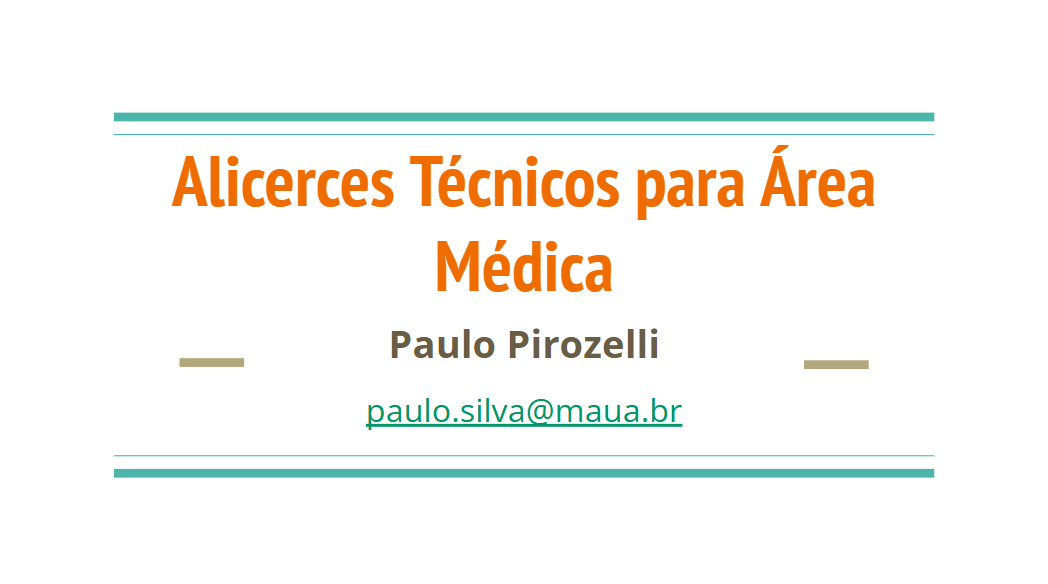

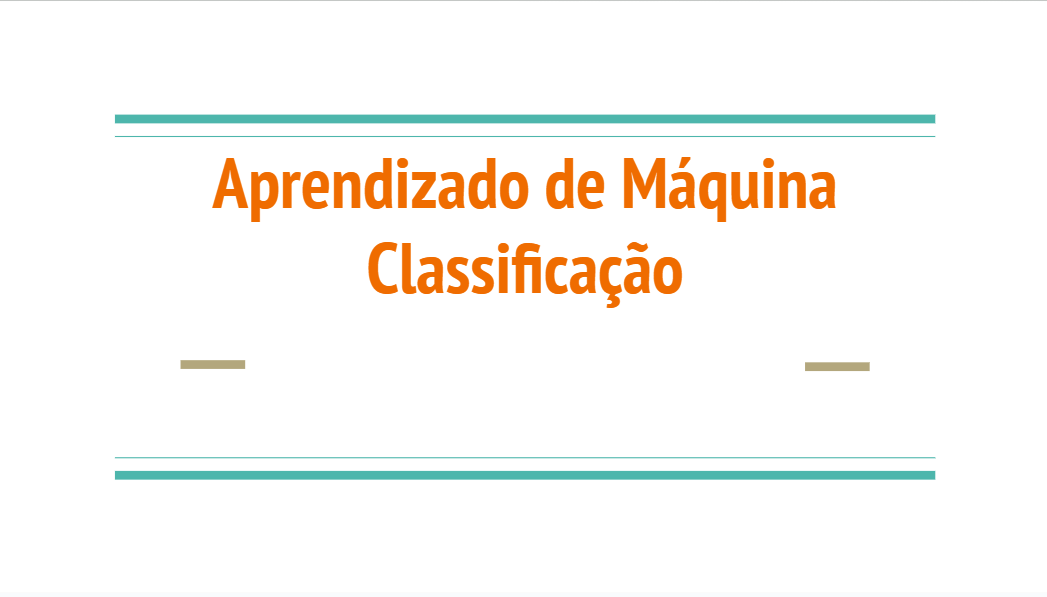

## Classificação

Dentro do paradigma de **Aprendizado Supervisionado**, existem dois tipos principais de tarefas: **regressão** e **classificação**.

Na aula passada, exploramos a tarefa de regressão, cujo objetivo é estimar um **valor contínuo**. Para isso, utilizamos um modelo clássico: a regressão linear. Já nesta aula, iremos abordar o segundo tipo de tarefa, a classificação, que tem como objetivo determinar a qual **classe** uma observação pertence.

Vamos partir de um exemplo motivador para nossa explicação.

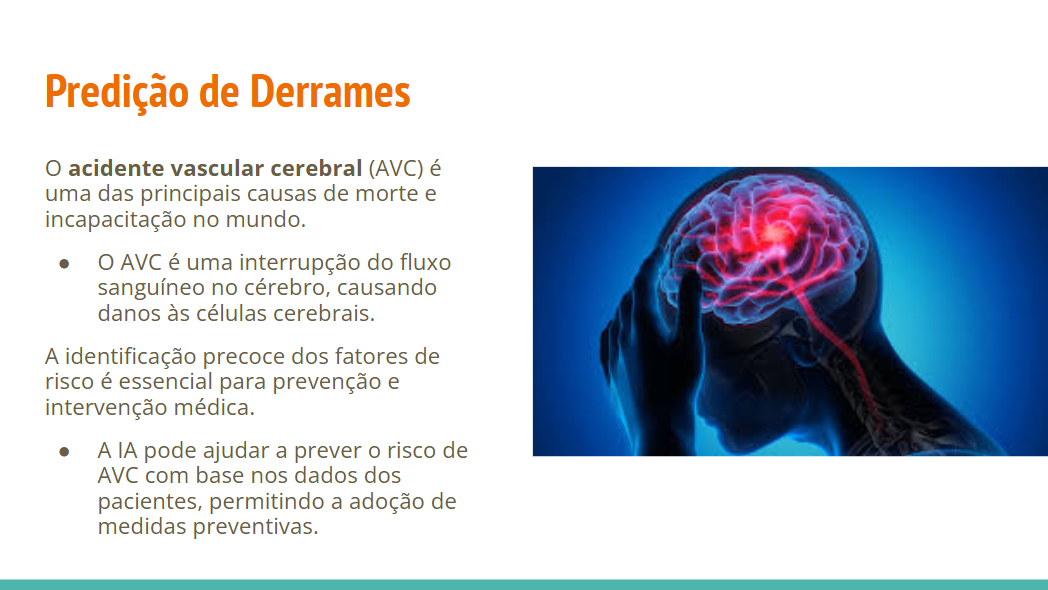

### Importação dos Dados

Para começar, vamos tentar abrir o conjunto de dados.

As informações estão em um arquivo no formato .csv (Comma-Separated Values). Nesse tipo de arquivo, as colunas são separadas por vírgulas ou algum outro separados e cada linha corresponde a um registro.

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

print('Tamanho do dataset:', df.shape)

df.head()

Tamanho do dataset: (5110, 12)


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [ ]:
# Verificando as colunas presentes no dataset
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

As variáveis presentes no dataset são as seguintes:

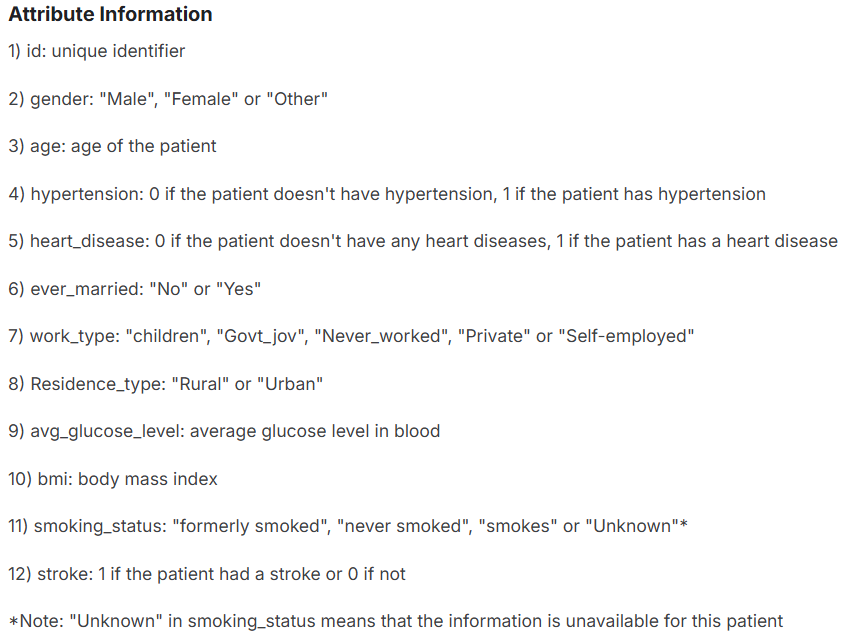

**Documentação completa:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

## Análise Exploratória

A primeira coisa a fazer é analisar as característiacs básicas do nosso conjunto de dados. Podemos, por exemplo, ver os tipos das variáveis e seus valores possíveis.

In [ ]:
# Checar os tipos das variáveis
print(df.dtypes)

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


### Estatísticas descritivas

Em seguida, podemos inspecionar as **estatísticas descritivas** do nosso dataset.

In [ ]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

Essas estatísticas descritivas só funcionam para variáveis quantitativas. Para variáveis qualitativas, podemos ver a distribuição por meio de gráficos de barras.

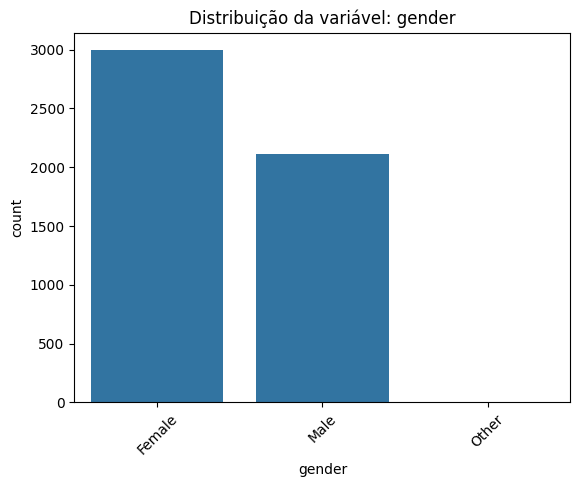

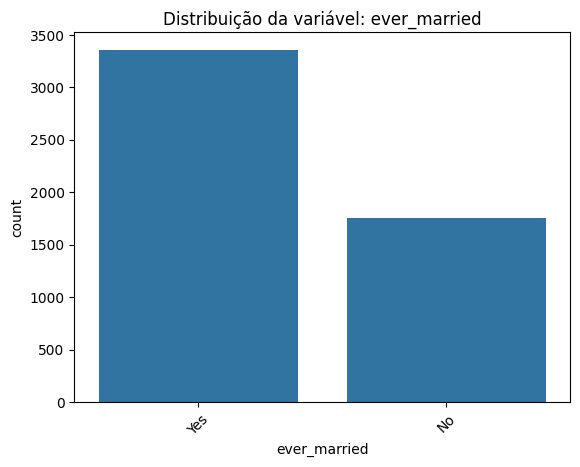

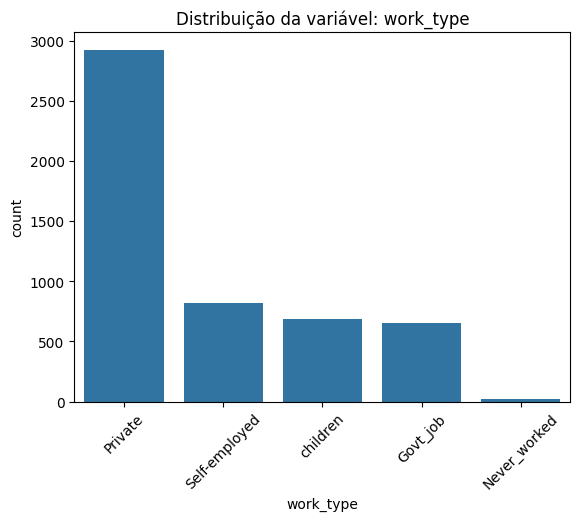

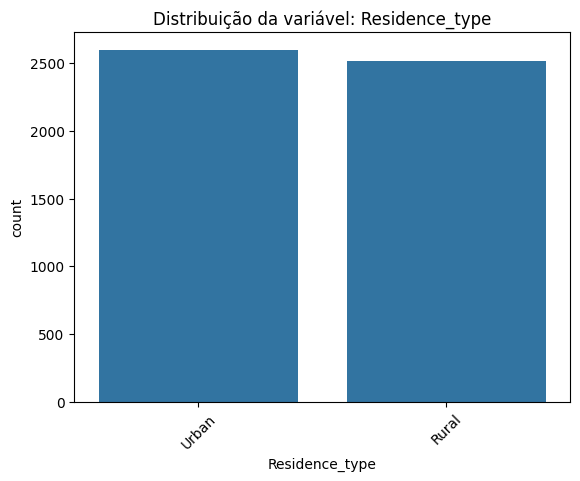

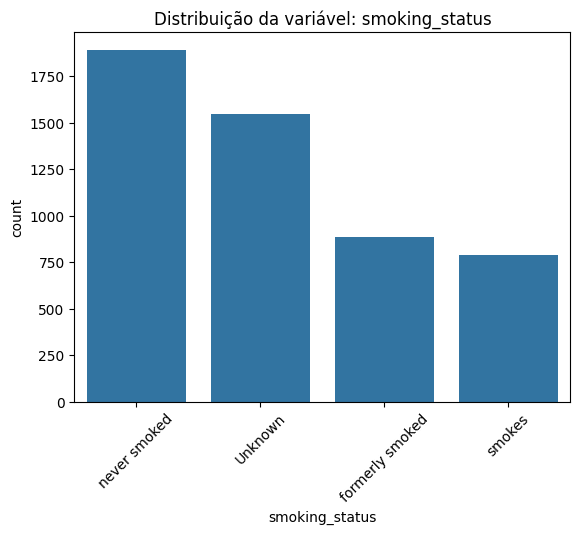

In [ ]:
# Detecta variáveis qualitativas (tipos object ou category)
qualitativas = df.select_dtypes(include=['object', 'category']).columns

# Cria um gráfico de barras para cada variável qualitativa
for coluna in qualitativas:
    sns.countplot(data=df, x=coluna, order=df[coluna].value_counts().index)
    plt.title(f'Distribuição da variável: {coluna}')
    plt.xticks(rotation=45)
    plt.show()

Podemos ainda inspecionar as correlações entre variáveis, para levantar hipóteses sobre os fatores determinantes do AVC.

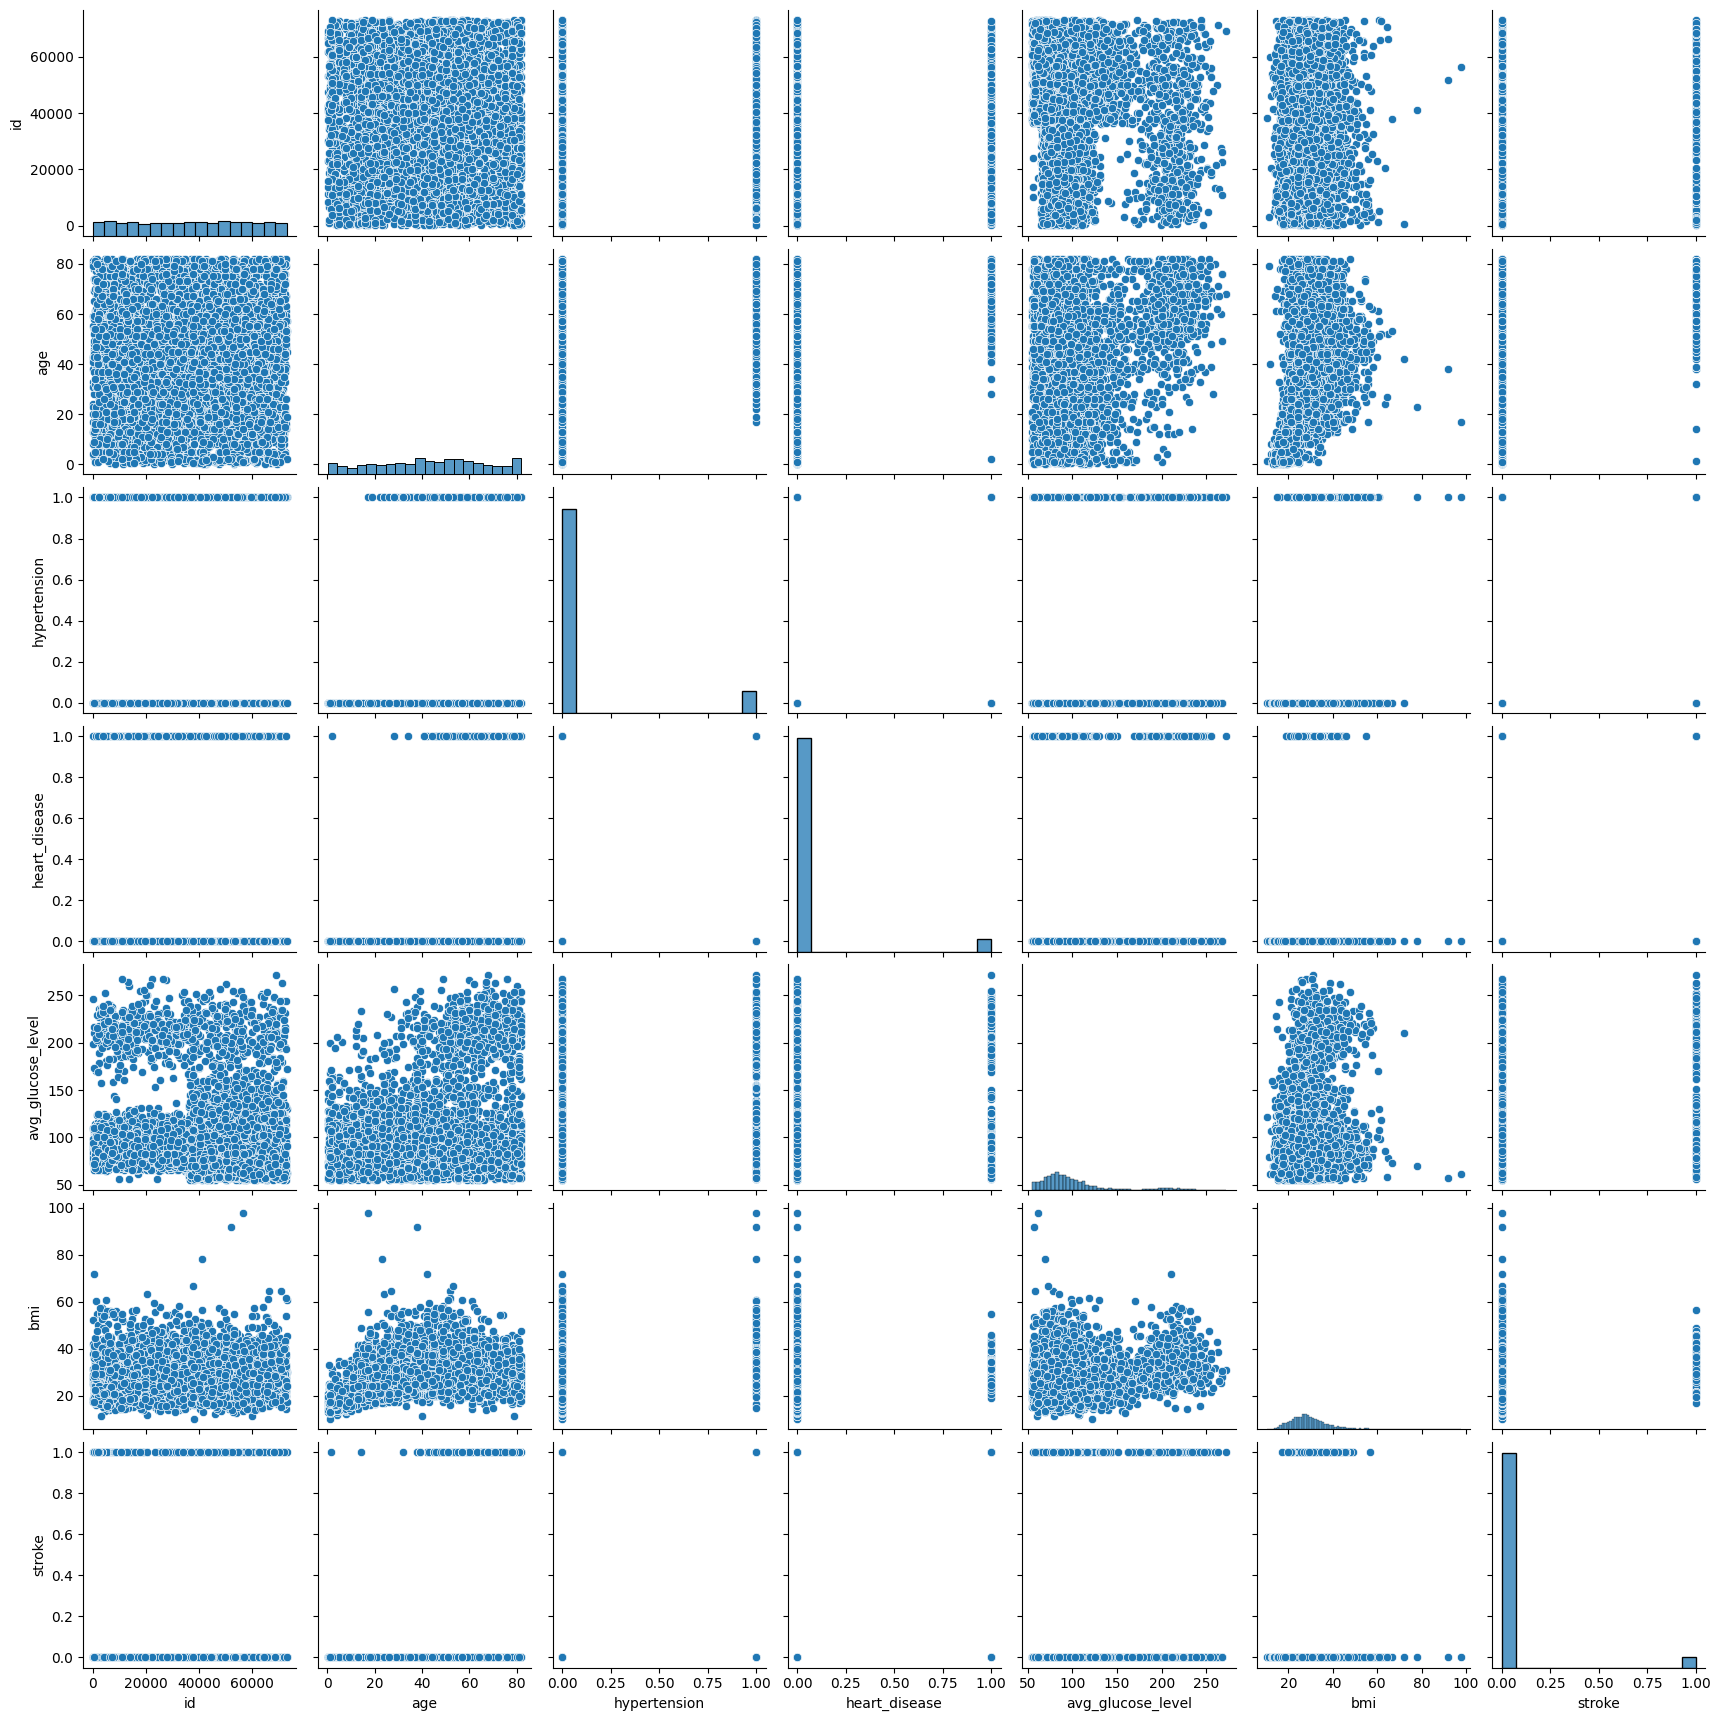

In [ ]:
# Gráficos de dispersão
sns.pairplot(df)
plt.show()

Podemos sistematizar essas relações com uma matriz de correlação.

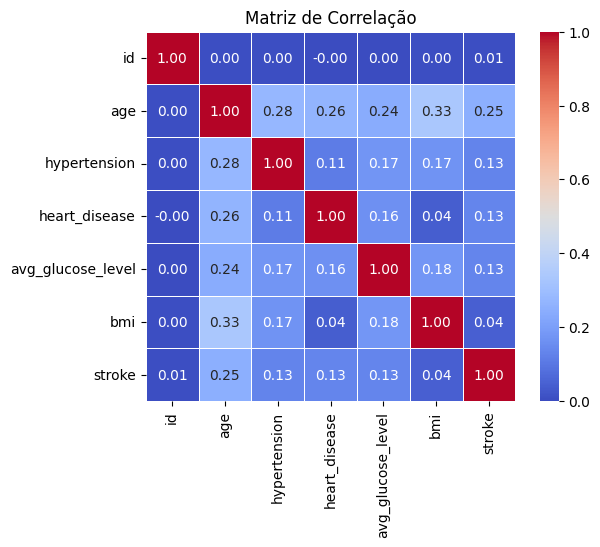

In [ ]:
# Seleciona apenas colunas numéricas
df_numerico = df.select_dtypes(include=['number'])

# Calcula a matriz de correlação
correlacao = df_numerico.corr()

# Exibe o heatmap
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

No caso de variáveis qualitativas, podemos considerar a distribuição dos valores por classe.

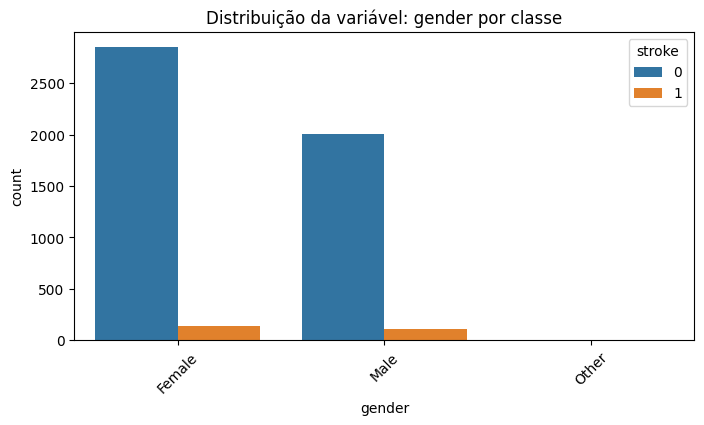

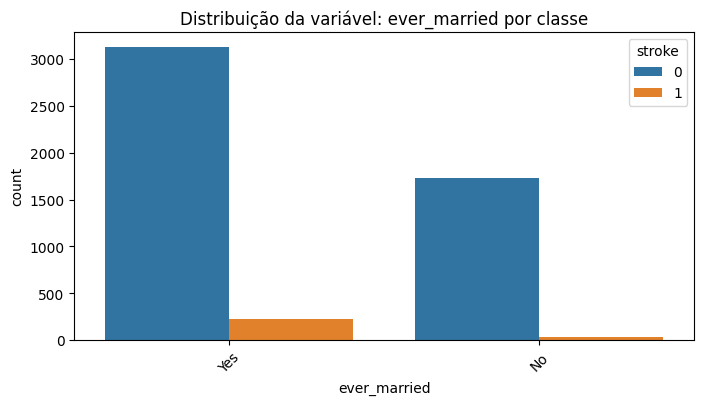

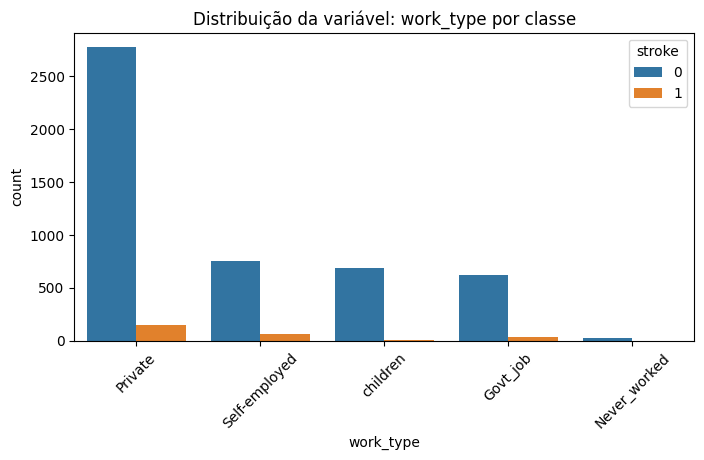

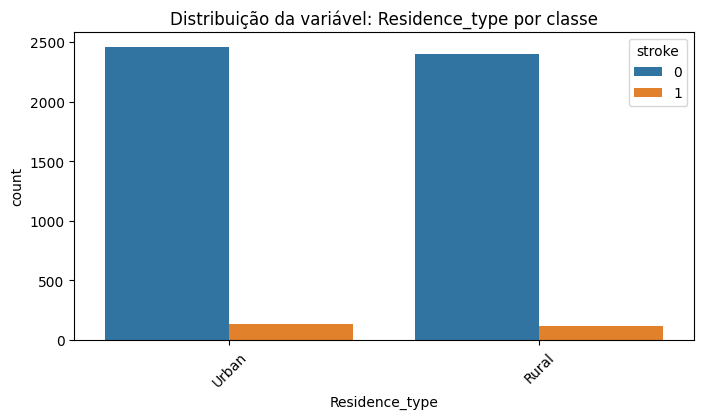

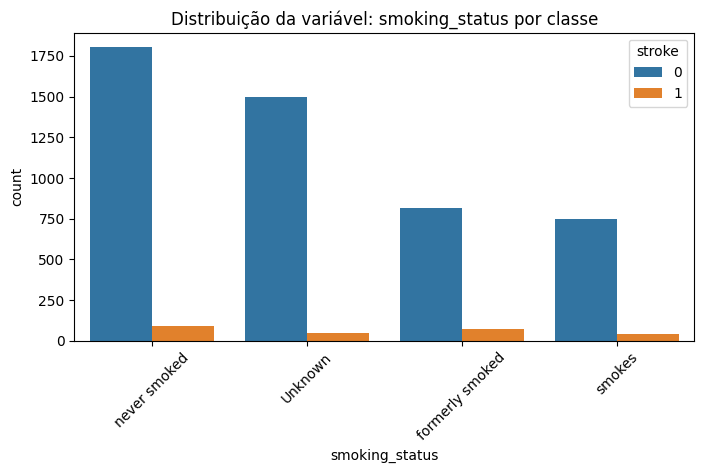

In [ ]:
# Cria um gráfico para cada variável qualitativa
for coluna in qualitativas:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=coluna, hue='stroke', order=df[coluna].value_counts().index)
    plt.title(f'Distribuição da variável: {coluna} por classe')
    plt.xticks(rotation=45)
    plt.show()

### Pré-processamento

#### 1. Integração de Bases de Dados

Nosso dataset já contém todas as informações. Não foi preciso integrar diferentes bases.

#### 2. Limpeza dos Dados

##### Dados Faltantes

Dados faltantes podem ser um problema sério para vários tipos de modelos, impedindo que possam rodar. Vamos checar se há valores faltantes e se houver, vamos removê-los.



In [ ]:
# Verificar valores faltantes
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Há 201 valores faltantes na coluna bmi. A solução que vou adotar é imputar a média da variável, que é um valor neutro.

In [ ]:
# Calcula a média (ignorando os NaNs)
media_bmi = df['bmi'].mean()

# Imputa os valores faltantes com a média
df['bmi'].fillna(media_bmi, inplace=True)

# Verifica se ainda restaram valores faltantes
print(f'Valores faltantes após imputação: {df["bmi"].isna().sum()}')

Valores faltantes após imputação: 0


<ipython-input-11-c111d7719539>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(media_bmi, inplace=True)


#### 3. Tipos de variáveis

Nossos dados contém variáveis de diferentes de tipos. Precisamos converter as variáveis categóricas em variáveis quantitativas.

In [ ]:
# Número de valores únicos em cada colunas
print('coluna | tipo | valores únicos')

for column in df.columns:
    unique_values = df[column].nunique()
    print(f"{column}, {df[column].dtype}, {unique_values}")

coluna | tipo | valores únicos
id, int64, 5110
gender, object, 3
age, float64, 104
hypertension, int64, 2
heart_disease, int64, 2
ever_married, object, 2
work_type, object, 5
Residence_type, object, 2
avg_glucose_level, float64, 3979
bmi, float64, 419
smoking_status, object, 4
stroke, int64, 2


Podemos ver que algumas dessas variáveis são quantitativas, outras são qualitativas. Mas algumas não são óbvias.

Podemos explorar alguns em mais detalhes, para entender o que são esses valores.

In [ ]:
# Detecta variáveis qualitativas (tipos object ou category)
qualitativas = df.select_dtypes(include=['object', 'category']).columns

# Imprime os valores únicos de cada uma
for coluna in qualitativas:
    print(f'\nColuna: {coluna}')
    print(df[coluna].unique())


Coluna: gender
['Male' 'Female' 'Other']

Coluna: ever_married
['Yes' 'No']

Coluna: work_type
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Coluna: Residence_type
['Urban' 'Rural']

Coluna: smoking_status
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


A variável `Residence_type` contém apenas dois valores (binária), que podemos substituir simplesmente por 0-1. As demais variáveis apresentam múltiplos rótulos. Para esses casos, vamos utilizar uma codificação one-hot ou dummy.

In [ ]:
# Codifica variáveis categóricas com one-hot encoding
df = pd.get_dummies(df, drop_first=True)

df

id   age  hypertension  heart_disease  avg_glucose_level        bmi  \
0      9046  67.0             0              1             228.69  36.600000   
1     51676  61.0             0              0             202.21  28.893237   
2     31112  80.0             0              1             105.92  32.500000   
3     60182  49.0             0              0             171.23  34.400000   
4      1665  79.0             1              0             174.12  24.000000   
...     ...   ...           ...            ...                ...        ...   
5105  18234  80.0             1              0              83.75  28.893237   
5106  44873  81.0             0              0             125.20  40.000000   
5107  19723  35.0             0              0              82.99  30.600000   
5108  37544  51.0             0              0             166.29  25.600000   
5109  44679  44.0             0              0              85.28  26.200000   

      stroke  gender_Male  gender_Other  ever_married_Yes  \
0          1         True         False              True   
1          1        False         False              True   
2          1         True         False              True   
3          1        False         False              True   
4          1        False         False              True   
...      ...          ...           ...               ...   
5105       0        False         False              True   
5106       0        False         False              True   
5107       0        False         False              True   
5108       0         True         False              True   
5109       0        False         False              True   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                      False               True                    False   
1                      False              False                     True   
2                      False               True                    False   
3                      False               True                    False   
4                      False              False                     True   
...                      ...                ...                      ...   
5105                   False               True                    False   
5106                   False              False                     True   
5107                   False              False                     True   
5108                   False               True                    False   
5109                   False              False                    False   

      work_type_children  Residence_type_Urban  \
0                  False                  True   
1                  False                 False   
2                  False                 False   
3                  False                  True   
4                  False                 False   
...                  ...                   ...   
5105               False                  True   
5106               False                  True   
5107               False                 False   
5108               False                 False   
5109               False                  True   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                               True                        False   
1                              False                         True   
2                              False                         True   
3                              False                        False   
4                              False                         True   
...                              ...                          ...   
5105                           False                         True   
5106                           False                         True   
5107                           False                         True   
5108                            True                        False   
5109                           False      

**Pergunta:** Por que eu usei a mesma solução para a variável binária?

In [ ]:
print(df.shape)

(5110, 18)


**Importante:** Essa transformação fez com que nosso dataset passasse de 12 para 18 colunas. Essa alteração pode dificultar a convergência e a precisão de alguns modelos, que terão que estimar muito mais parâmetros simultaneamente.

#### 4. Outliers

Vou deixar para resolver o problema dos valores extremos com o escalonamento.

#### 5. Escalonamento

Vamos também escalonar os nossos dados, utilizando uma estratégia z-score. As variáveis terão aproximadamente média 0 e desvio-padrão 1.

**Importante:** Antes, precisamos separar nossos dados de entrada e saída (não queremos normalizar os dados de saída). Depois vamos juntar com os dados de entrada normalizados.

In [ ]:
y = df['stroke']

# Elimina a coluna de saída
X = df.drop(columns=['stroke'])

print(X.shape)

(5110, 17)


In [ ]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

# Print dataset normalizado
print('Tamanho do dataset:', X.shape)
print(X)

Tamanho do dataset: (5110, 17)
[[-1.29831203  1.05143428 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.71637149  0.78607007 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [-0.25547819  1.62639008 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 ...
 [-0.79371959 -0.36384151 -0.32860186 ... -0.45767615  1.30416474
  -0.42731326]
 [ 0.04849658  0.34379639 -0.32860186 ...  2.1849511  -0.7667743
  -0.42731326]
 [ 0.38569496  0.03420481 -0.32860186 ... -0.45767615 -0.7667743
  -0.42731326]]


#### 6. Balanceamento de Dados

Em tarefas de classificação, é preciso garantir que as classes sejam igualmente representadas (ou algo próximo disso). De outra forma, o modelo pode se preocupar demais com a classe majoritária e deixar de lado a classe minoritária.


**Dados desbalanceados:**

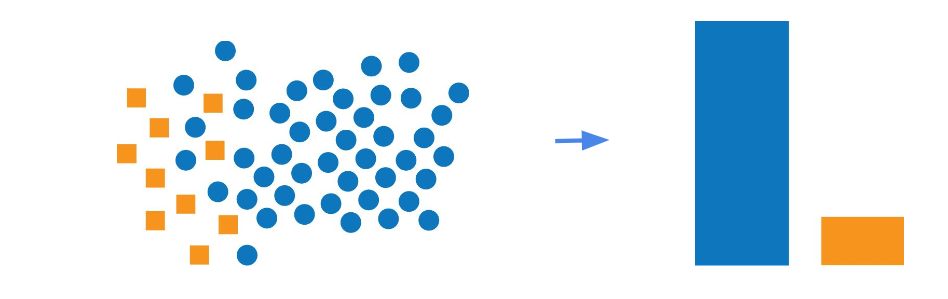

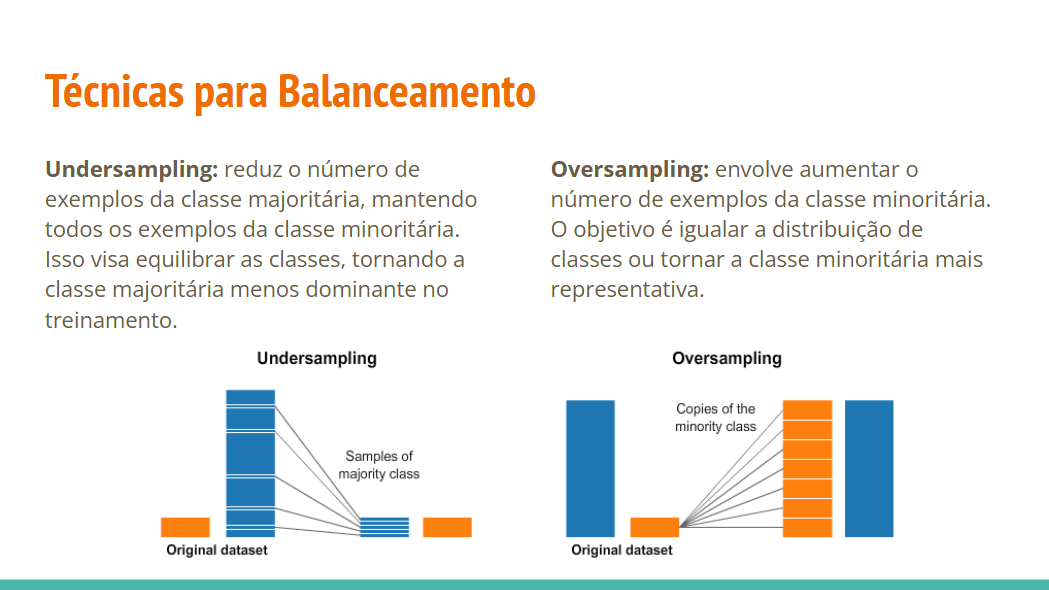

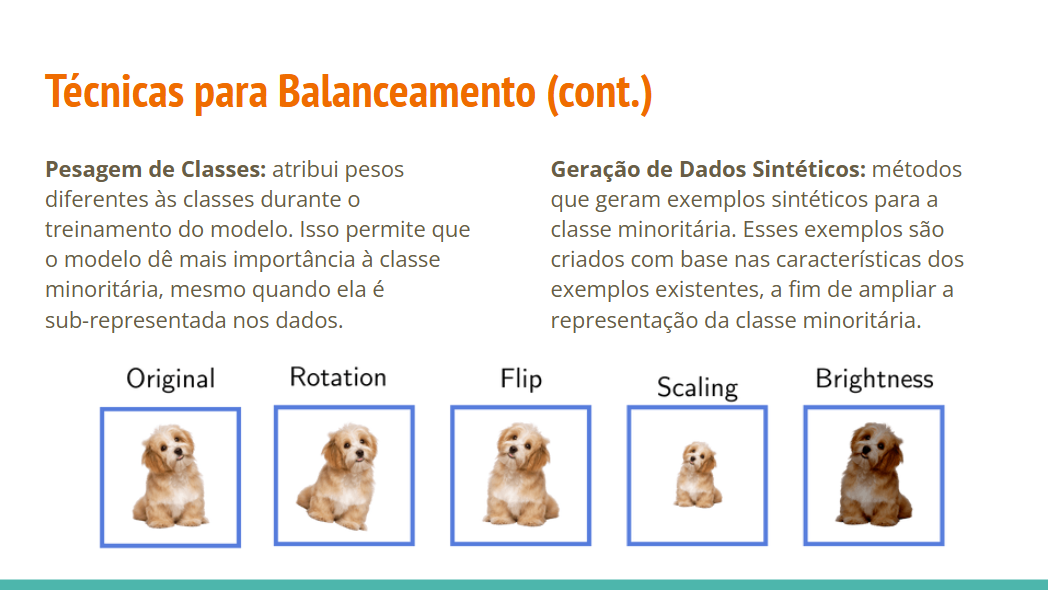

Vamos verificar se o nosso conjunto de dados é desbalanceado em relação à variável de interesse.

In [ ]:
# Verificar balanceamento do dataset
print('Valor Absoluto')
print(df['stroke'].value_counts())
print('\n')

print('Valor Percentual')
print(df['stroke'].value_counts() / len(df) * 100)

Valor Absoluto
stroke
0    4861
1     249
Name: count, dtype: int64


Valor Percentual
stroke
0    95.127202
1     4.872798
Name: count, dtype: float64


Nessa aula, não vamos usar nenhuma técnica para garantir o balanceamento dos dados. Vamos apenas exigir que as classes estejam **estratificadas**; isto é, que a proporção das classes seja a mesma no conjunto treinamento e teste.

In [ ]:
# Partição estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Dataset de treinamento:', X_train.shape)
print('Dataset de teste:', X_test.shape)

Dataset de treinamento: (4088, 17)
Dataset de teste: (1022, 17)


## Métricas

Antes de fazermos o treinamento dos nossos modelos, precisamos definir uma **métrica** que permita avaliar a qualidade dos modelos.

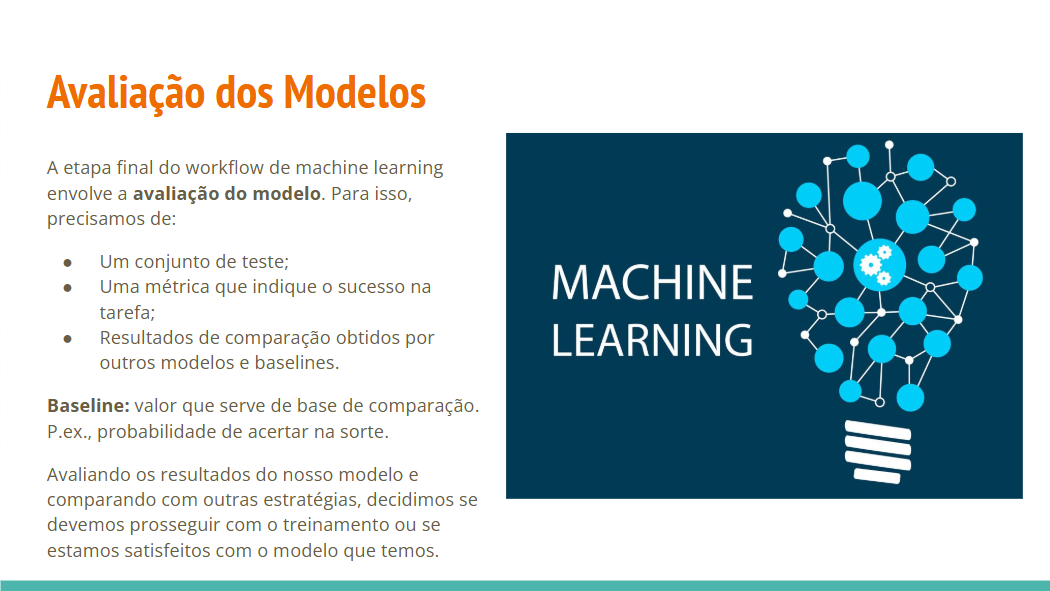

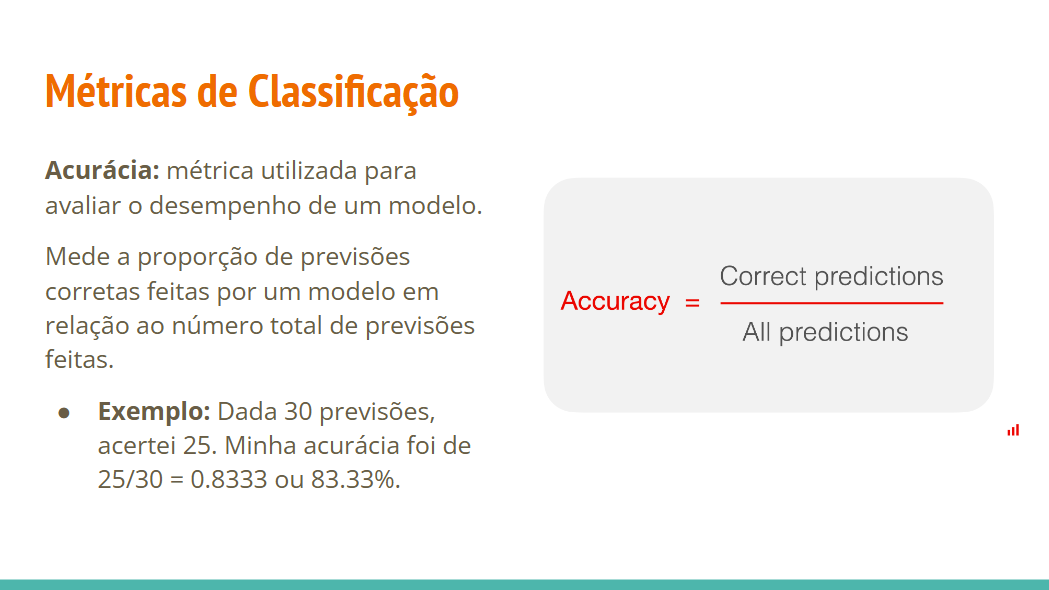

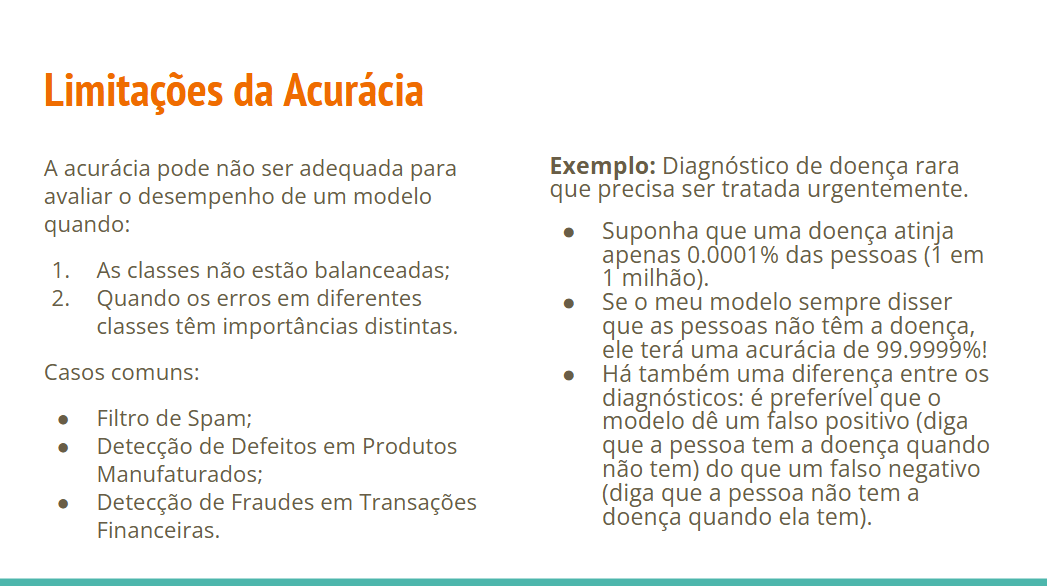

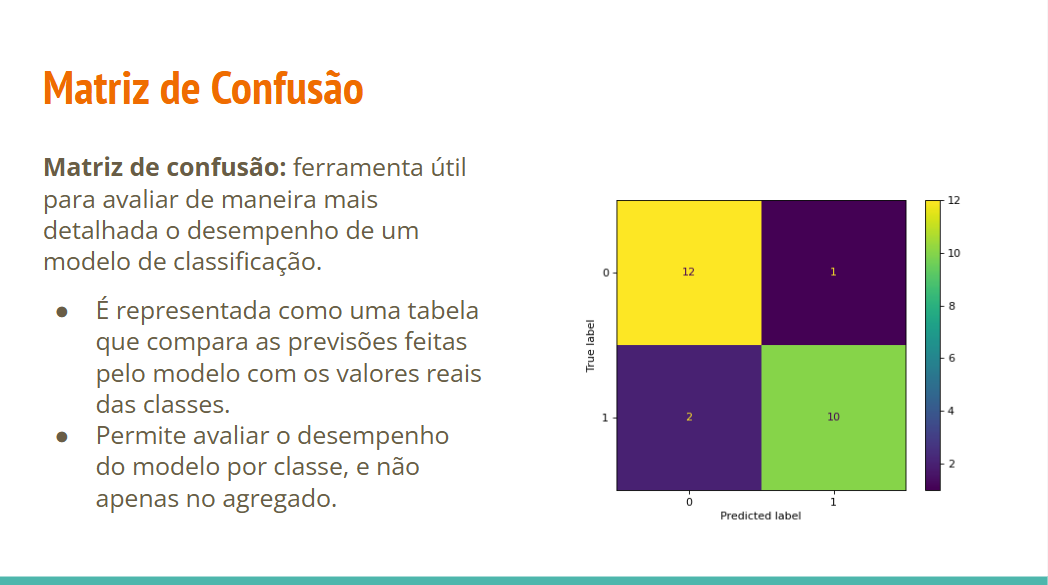

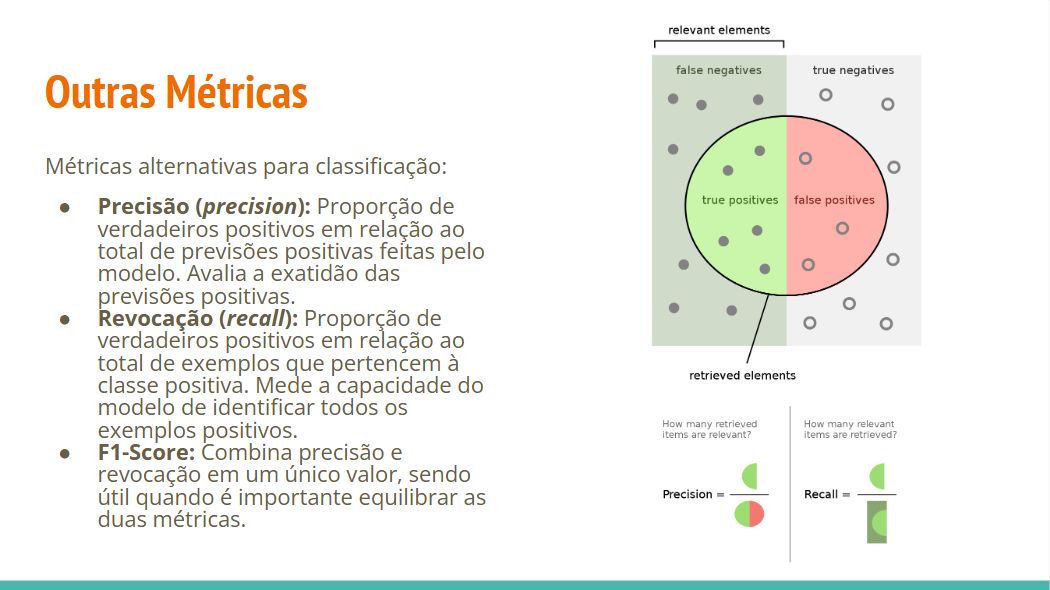

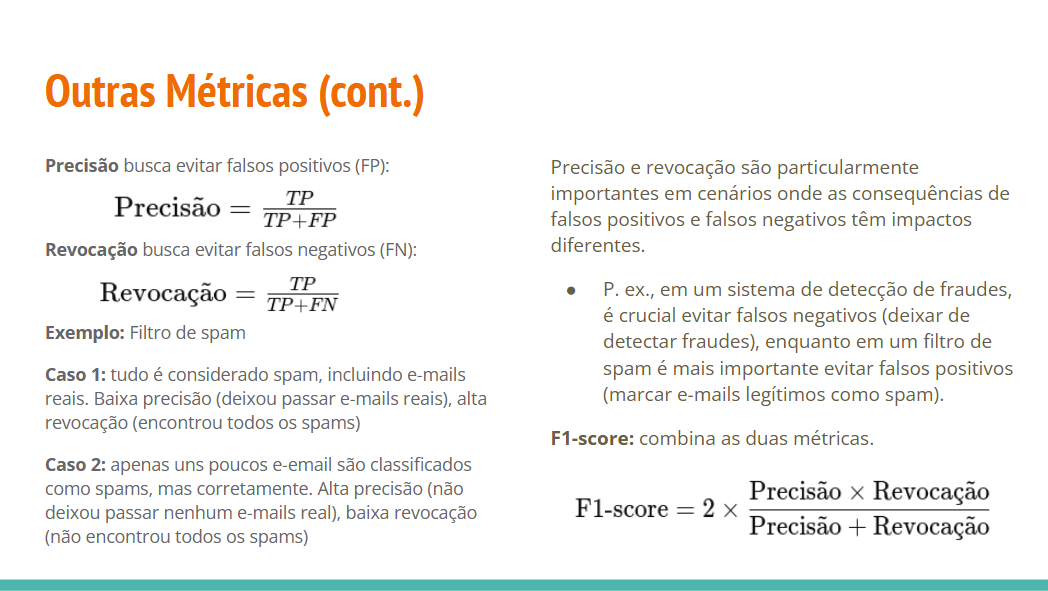

Vamos usar essas duas métricas de classificação nas nossas avaliações: **acurácia** e **f1-score**.

## Modelos

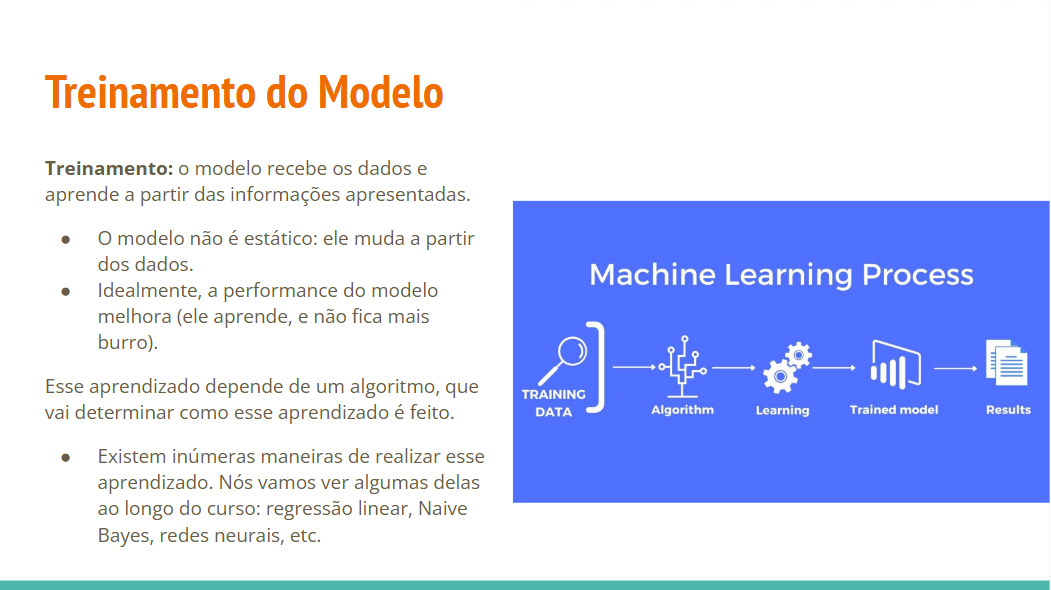

Nesta aula, veremos alguns modelos clássicos de classificação, como regressão logística e k-vizinhos próximos.

### Regressão Logística

O primeiro modelo de classificação que iremos estudar é a **regressão logísitca**. Esse modelo nada mais é do que uma adaptação da regressão linear usada para classificação, que restringe os valores de saída ao intervalor entre 0 e 1.

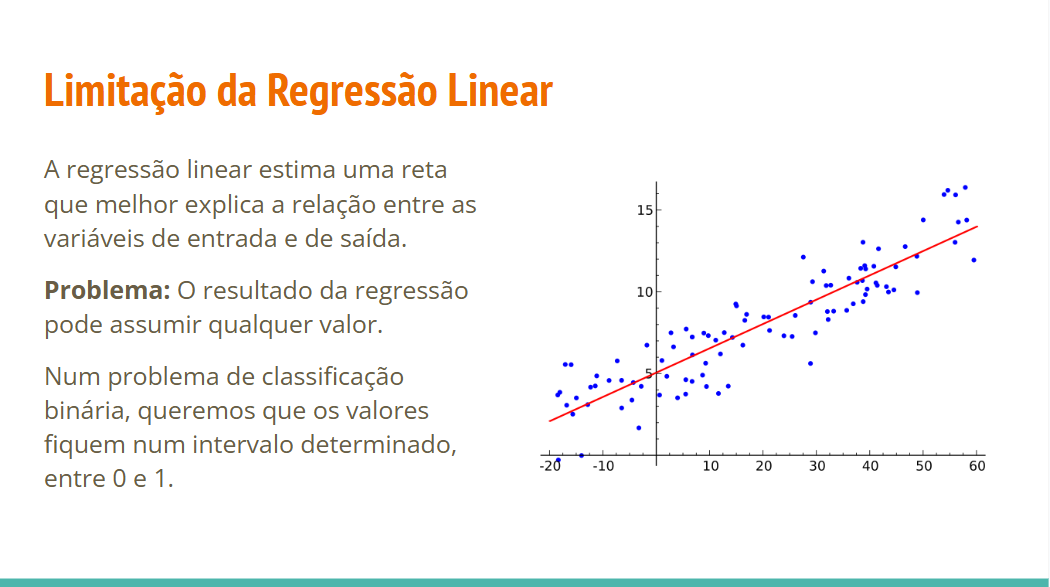

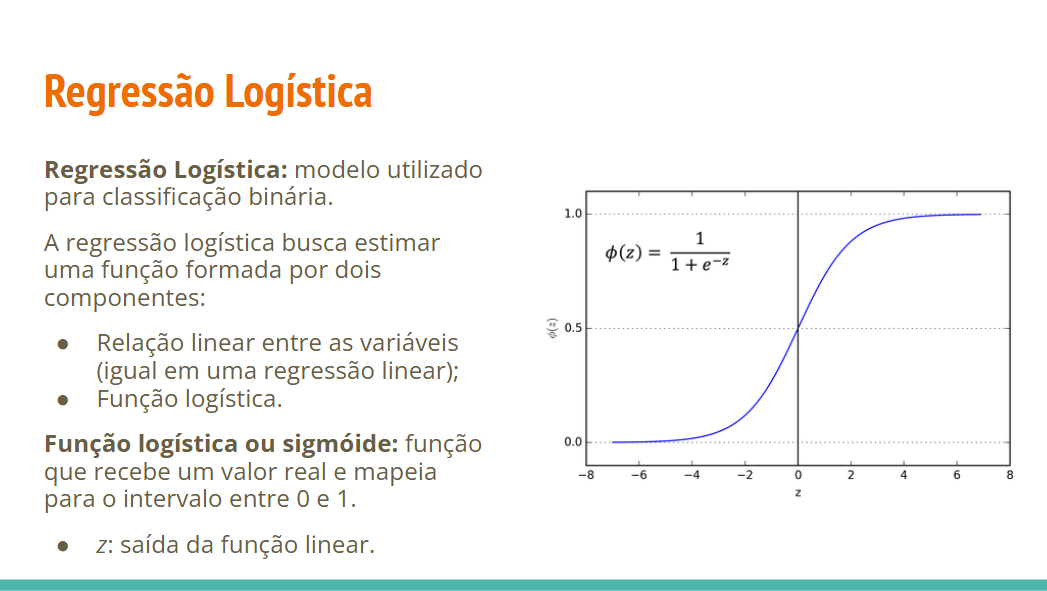

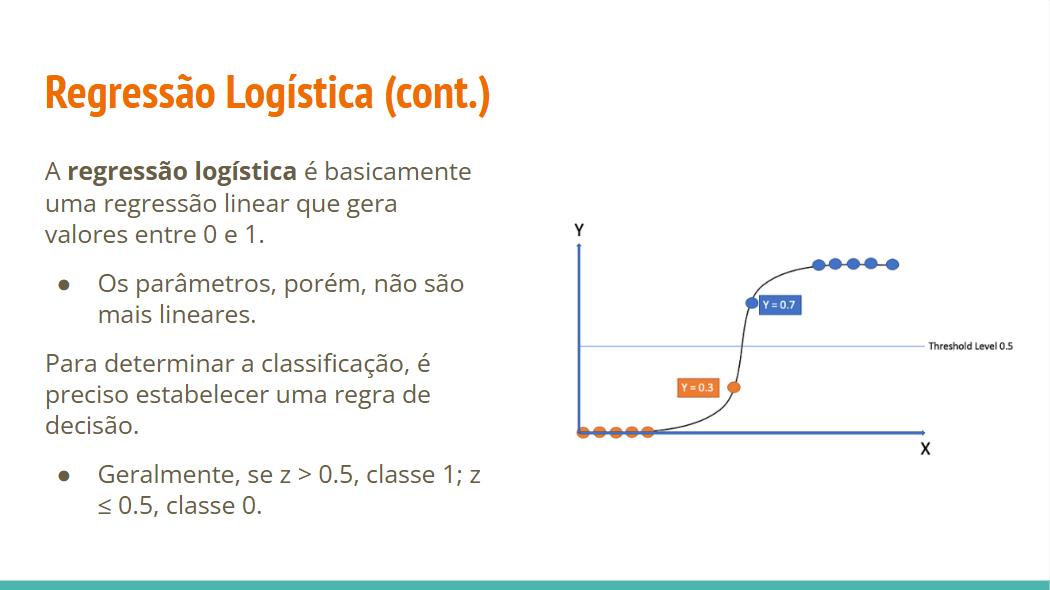

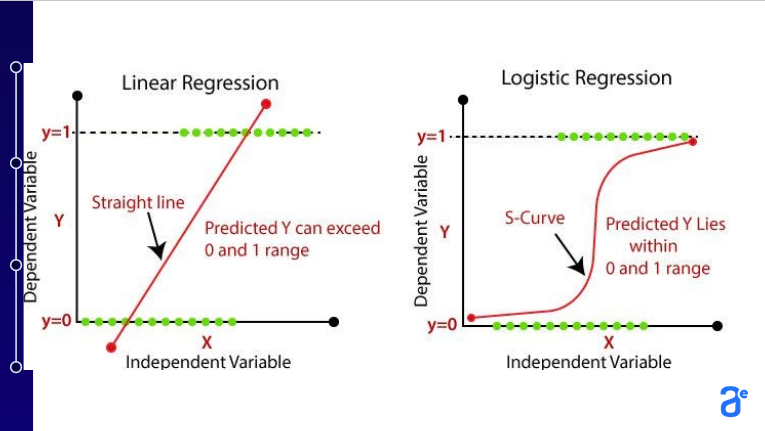

Vamos treinar a nossa regressão logística para determinar quais clientes aceitam o produto financeiro.

Iremos salver os valores desse classificador em um dicionário para comparar com outros modelos que veremos mais à frente.

In [ ]:
class_metrics = {}

Quando trabalhamos com machine learning, o processo de ajuste é feito sempre no conjunto treinamento. Em seguida, o modelo ajustado é aplicado ao conjunto teste, para avaliar sua capacidade de generalização.

In [ ]:
# Cria o modelo
reglog = LogisticRegression()

# Ajusta os parâmetros do modelo
reglog.fit(X_train, y_train)

# Aplica ao conjunto teste
y_pred = reglog.predict(X_test)

# Calcula as métricas de desempenho
reglog_acc = accuracy_score(y_test, y_pred)
reglog_f1 = f1_score(y_test, y_pred)

class_metrics['LogRegression'] = [reglog_acc, reglog_f1]

print(f'Regressão logística. Acurácia: {reglog_acc * 100:.4}%, F1-score: {reglog_f1 * 100:.4}%')

Regressão logística. Acurácia: 95.11%, F1-score: 3.846%


### K-Vizinhos Próximos

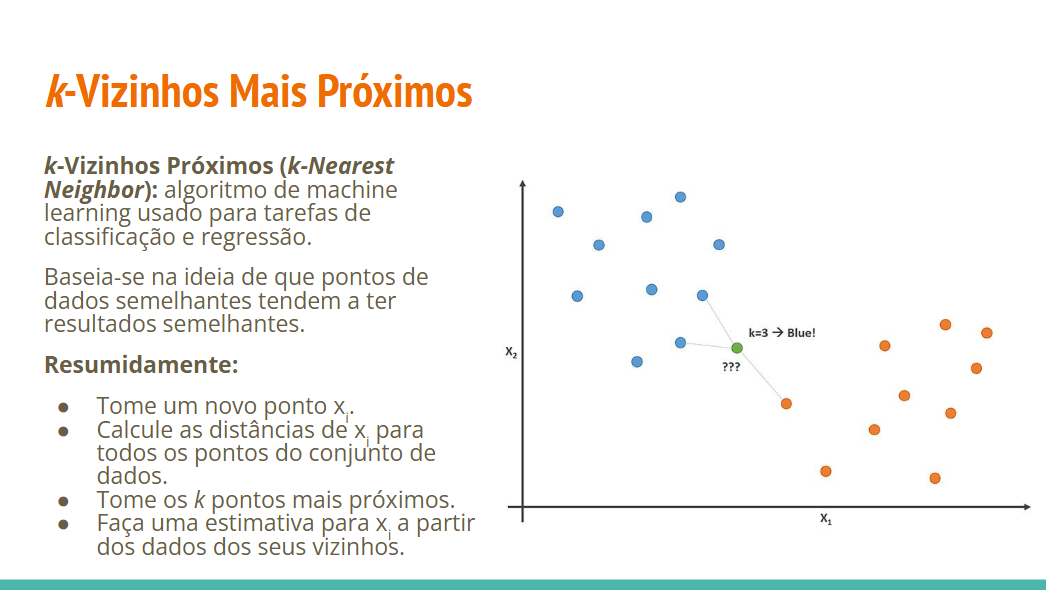

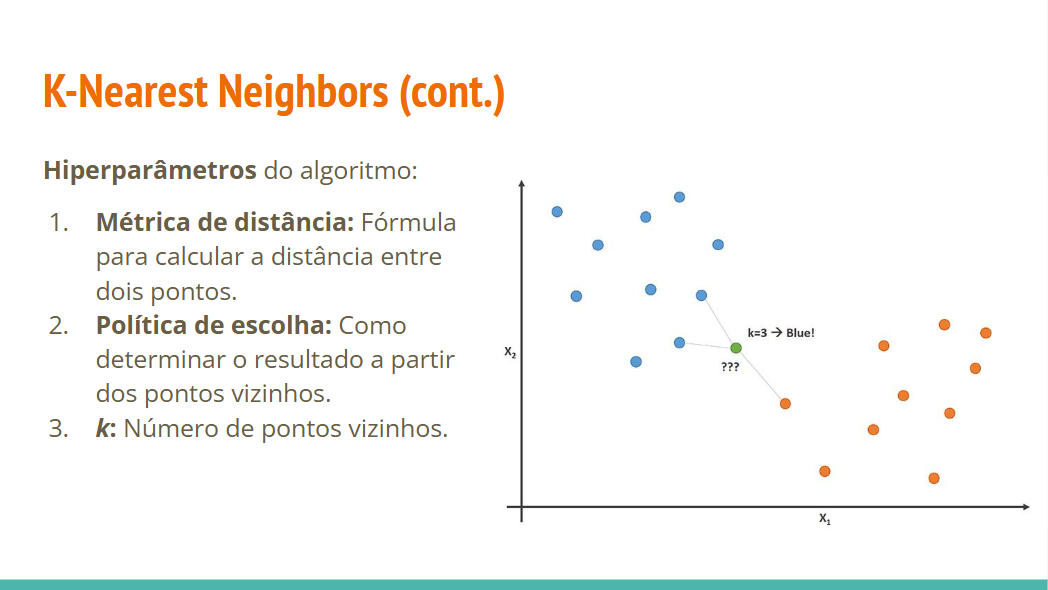

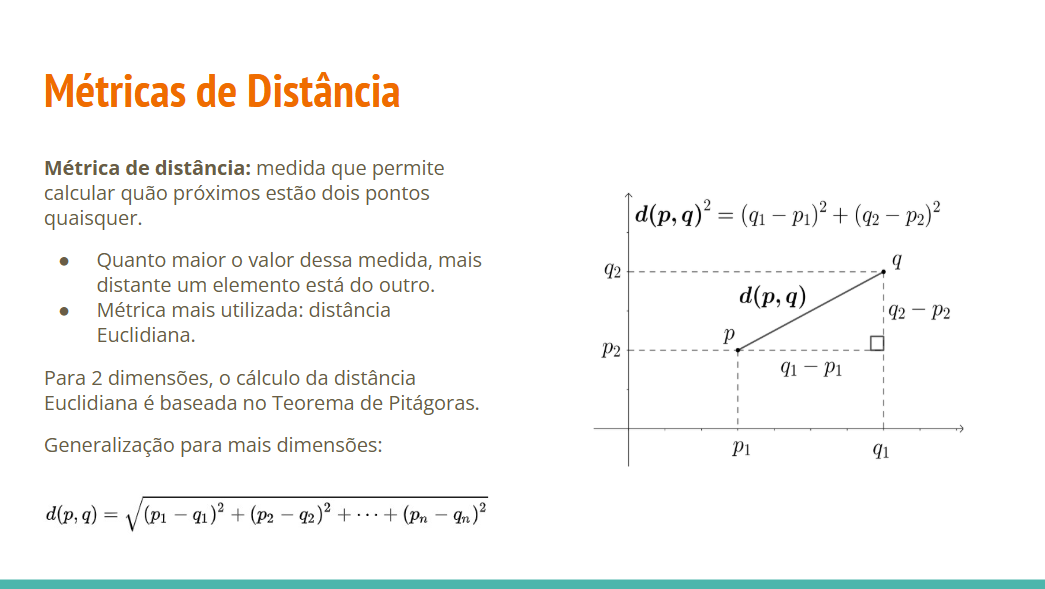

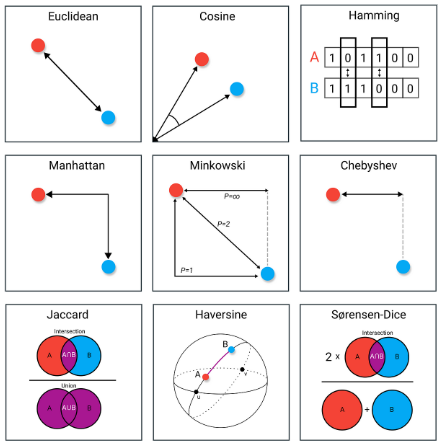

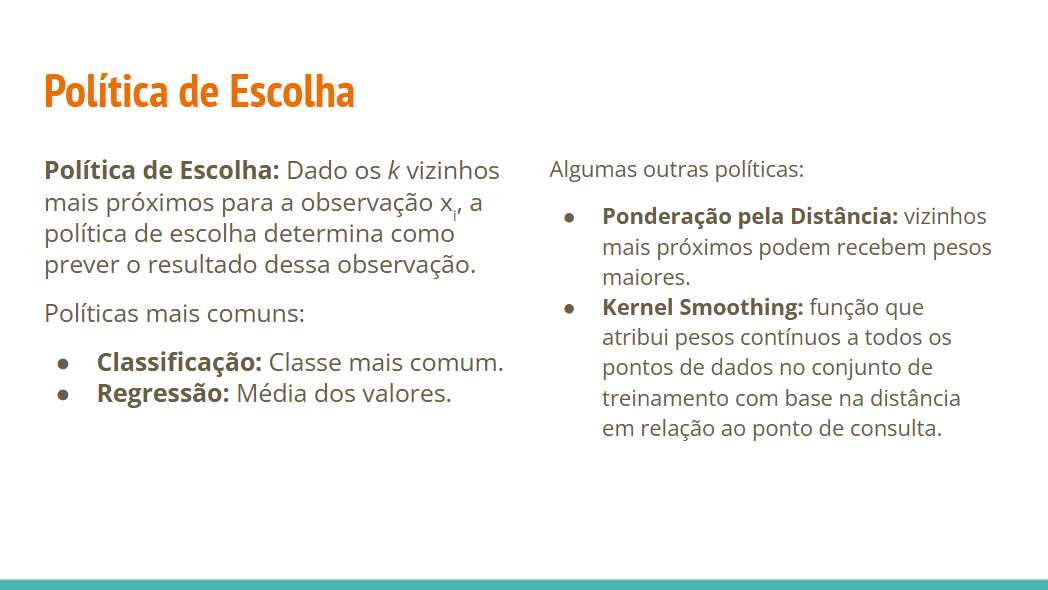

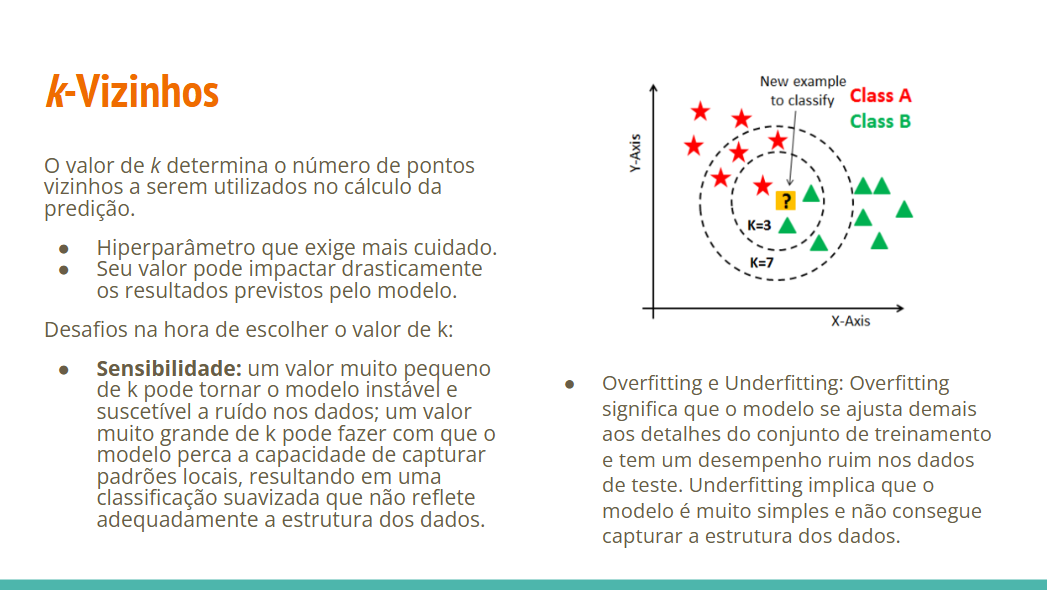

Vamos treinar um modelo k-NN sobre os nossos dados.

In [ ]:
# Cria o modelo
knn = KNeighborsClassifier(n_neighbors=3)

# Ajusta os parâmetros
knn.fit(X_train, y_train)

# Aplica ao conjunto teste
y_pred = knn.predict(X_test)

# Calcula as métricas de desempenho
knn_acc = accuracy_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)

class_metrics['kNN'] = [knn_acc, knn_f1]

print(f'k-NN. Acurácia: {knn_acc * 100:.4}%, F1-score: {knn_f1 * 100:.4}%')

k-NN. Acurácia: 94.62%, F1-score: 9.836%


Para comparar os resultados, podemos plotar um gráfico. Para isso, definimos uma função que, quando chamada, exibe os resultados armazenados no dicionário.

In [19]:
def plot_model_metrics(metrics_dict):
    models = list(metrics_dict.keys())
    accuracy = [val[0] for val in metrics_dict.values()]
    fscore = [val[1] for val in metrics_dict.values()]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, accuracy, width, label='Accuracy')
    plt.bar(x + width/2, fscore, width, label='F-score')
    plt.xticks(x, models)
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

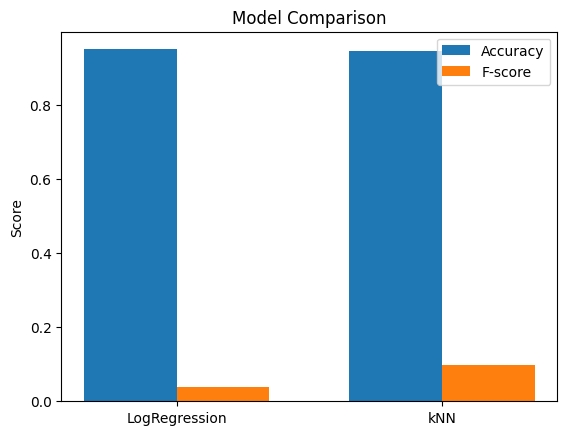

In [ ]:
plot_model_metrics(class_metrics)

## Exercício: Dataset Íris

O **Dataset Iris** é um dos conjuntos de dados mais conhecidos em Machine Learning. Ele contém informações sobre três espécies de flores do gênero *Iris* (**Iris setosa, Iris versicolor e Iris virginica**), com medidas de suas pétalas e sépalas. O objetivo deste exercício é desenvolver um modelo de **classificação** que consiga prever a espécie da flor a partir dessas medidas.

### **Objetivo**
Treinar um modelo de regressão linear e um modelo de k-NN para classificar corretamente a espécie da flor com base em suas características. Teste diferentes hiperparâmetros para este último.

### **Dados**
O dataset Iris pode ser baixado no seguinte link:

📥 **Baixar o dataset:**  
[https://archive.ics.uci.edu/ml/datasets/iris](https://archive.ics.uci.edu/ml/datasets/iris)  

Ele também pode ser carregado diretamente via scikit-learn com o seguinte código:

```python
from sklearn.datasets import load_iris
data = load_iris()


In [5]:
from sklearn.datasets import load_iris
dataset = load_iris()

In [35]:
X = dataset.data
y = dataset.target

In [39]:
pd.value_counts(y)

<ipython-input-39-0e04e23f3b37>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y)


0    50
1    50
2    50
Name: count, dtype: int64

In [59]:
# Partição estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

print('Dataset de treinamento:', X_train.shape)
print('Dataset de teste:', X_test.shape)

Dataset de treinamento: (135, 4)
Dataset de teste: (15, 4)


In [60]:
results = {}

In [61]:
# Cria o modelo de Regressão Logística
reglog = LogisticRegression()

# Ajusta os parâmetros do modelo
reglog.fit(X_train, y_train)

# Aplica ao conjunto teste
y_pred = reglog.predict(X_test)

# Calcula as métricas de desempenho
reglog_acc = accuracy_score(y_test, y_pred)
reglog_f1 = f1_score(y_test, y_pred, average='weighted')

results['LogRegression'] = [reglog_acc, reglog_f1]

print(f'Regressão logística. Acurácia: {reglog_acc * 100:.4}%, F1-score: {reglog_f1 * 100:.4}%')

Regressão logística. Acurácia: 93.33%, F1-score: 93.27%


In [63]:
 # Cria o modelo
knn = KNeighborsClassifier(n_neighbors=5)

# Ajusta os parâmetros
knn.fit(X_train, y_train)

# Aplica ao conjunto teste
y_pred = knn.predict(X_test)

# Calcula as métricas de desempenho
knn_acc = accuracy_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred, average='weighted')

results['kNN'] = [knn_acc, knn_f1]

print(f'k-NN. Acurácia: {knn_acc * 100:.4}%, F1-score: {knn_f1 * 100:.4}%')

k-NN. Acurácia: 100.0%, F1-score: 100.0%


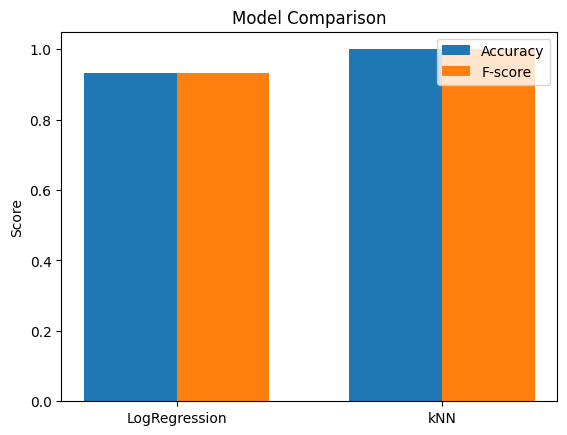

In [64]:
plot_model_metrics(results)